### **Factor Backtesting**

In [19]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from function import *
from config import *

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5000) 

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore') 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### **Hyperparameters**

In [20]:
c_rate = 1.2 / 10000  # 手续费
t_rate = 1 / 1000  # 印花税
select_stock_num = 3  # 选股数，当选股数为None时，会等权买入所有，当选股数小于0时，会看做百分比，用百分比进行选股。

#### **Backtesting Function**

In [35]:
def factor_testing(df:pd.DataFrame, factor:str, order:bool) -> pd.DataFrame:

    """
    df: 传入要测试的h5文件/pickle文件，月度或周度的数据
    factor：可取'总市值'、'流通市值'、'本周期涨跌幅'、'换手率'、'振幅1'、'振幅2'、'量价相关系数'
    order：True或False，代表取因子排名前若干只股票或后若干只股票
    """

    global select_stock_num, c_rate, t_rate, back_test_start, back_test_end, stock_data_path, index_data_path

    index_data = import_index_data(index_data_path + "\\sh000001.csv", start=back_test_start, end=back_test_end)

    # 创造空的事件周期表，用于填充不选股的周期
    empty_df = create_empty_data(index_data, period)

    df.dropna(subset=['下周期每天涨跌幅'], inplace=True) 

    # ===选股
    # 删除下个交易日不交易、开盘涨跌停、一字涨跌停的股票，因为这些股票在下个交易日开盘时不能买入
    df = df[df['下日_是否交易'] == 1]
    # df = df[df['下日_开盘涨停'] == False]
    # df = df[df['下日_一字涨停'] == False]
    # df = df[df['下日_开盘跌停'] == False]
    # df = df[df['下日_一字跌停'] == False]
    df = df[df['下日_是否ST'] == False]
    df = df[df['下日_是否S'] == False]
    df = df[df['下日_是否退市'] == False]

    # 计算选股因子，根据选股因子对股票进行排名
    df.dropna(subset=[factor], inplace=True)
    df['排名'] = df.groupby('交易日期')[factor].rank(ascending=order, method='first')
    df['排名_百分比'] = df.groupby('交易日期')[factor].rank(ascending=order, pct=True, method='first')

    # 选取排名靠前的股票，因子选股
    if select_stock_num:
        if select_stock_num >= 1:
            df = df[df['排名'] <= select_stock_num]
        else:
            df = df[df['排名_百分比'] <= select_stock_num]

    # 因为我们是开盘买入的方式，需修正选中股票在下周期每天的涨跌幅
    # 即将下周期每天的涨跌幅中第一天的涨跌幅，改成由开盘日内涨跌幅
    # 按照开盘买入的方式，修正选中股票在下周期每天的涨跌幅。
    # 即将下周期每天的涨跌幅中第一天的涨跌幅，改成由开盘买入的涨跌幅
    df['下日_开盘买入涨跌幅'] = df['下日_开盘买入涨跌幅'].apply(lambda x: [x])
    df['下周期每天涨跌幅'] = df['下周期每天涨跌幅'].apply(lambda x: x[1:])
    df['下周期每天涨跌幅'] = df['下日_开盘买入涨跌幅'] + df['下周期每天涨跌幅']
    # print(df[['交易日期', '股票名称', '下日_开盘买入涨跌幅', '下周期每天涨跌幅']].head(6))

    # ===整理选中股票数据
    # 挑选出选中股票
    df['股票代码'] += ' '
    df['股票名称'] += ' '
    group = df.groupby('交易日期')
    select_stock = pd.DataFrame()
    select_stock['买入股票代码'] = group['股票代码'].sum()
    select_stock['买入股票名称'] = group['股票名称'].sum()

    # 计算下周期每天的资金曲线
    select_stock['选股下周期每天资金曲线'] = group['下周期每天涨跌幅'].apply(lambda x: np.cumprod(np.array(list(x))+1, axis=1).mean(axis=0))
    # 扣除买入的手续费
    select_stock['选股下周期每天资金曲线'] = select_stock['选股下周期每天资金曲线'] * (1 - c_rate)  # 计算有不精准的地方
    # 扣除卖出手续费、印花税。最后一天的资金曲线值，扣除印花税、手续费
    select_stock['选股下周期每天资金曲线'] = select_stock['选股下周期每天资金曲线'].apply(lambda x: list(x[:-1]) + [x[-1] * (1-c_rate-t_rate)])

    # 计算下周期整体涨跌幅
    select_stock['选股下周期涨跌幅'] = select_stock['选股下周期每天资金曲线'].apply(lambda x: x[-1] - 1)

    # 再计算下周期每天的涨跌幅
    # 这个涨跌幅就不是我们之前那些从涨跌幅调整过来的了，而是我们扣除了各种税和费用之后的资金曲线回过来算出实际的下周期每日涨跌幅
    select_stock['选股下周期每天涨跌幅'] = select_stock['选股下周期每天资金曲线'].apply(lambda x: list(pd.DataFrame([1] + x).pct_change()[0].iloc[1:]))
    del select_stock['选股下周期每天资金曲线']

    # 计算整体资金曲线，就是这个策略的整体资金曲线，之前的是每个持仓周期内部的一个资金曲线
    select_stock.reset_index(inplace=True)
    select_stock['资金曲线'] = (select_stock['选股下周期涨跌幅'] + 1).cumprod()
    # print(select_stock.tail(50))
    select_stock.set_index('交易日期', inplace=True)
    empty_df.update(select_stock)
    select_stock = empty_df
    select_stock.reset_index(inplace=True, drop=False)

    # 至此，得到的数据是周度/月度的，希望和指数合并获取每日的资金曲线情况
    # ===计算选中股票每天的资金曲线
    equity = pd.merge(left=index_data, right=select_stock[['交易日期', '买入股票代码','买入股票名称']], on=['交易日期'],how='left', sort=True)  # 将选股结果和大盘指数合并，并进行排序

    equity['持有股票代码'] = equity['买入股票代码'].shift(1) #持有股票代码等于买入股票代码下移一天
    equity['持有股票代码'].fillna(method='ffill', inplace=True) #按前一位填充
    equity.dropna(subset=['持有股票代码'], inplace=True)
    del equity['买入股票代码']
    # # 似乎不需要（加上这几行下面就会报错，报那个行数不匹配的错误，应该是和dropna有关）：
    # equity['持有股票名称'] = equity['买入股票名称'].shift(1) #持有股票代码等于买入股票代码下移一天
    # equity['持有股票名称'].fillna(method='ffill', inplace=True) #按前一位填充
    # equity.dropna(subset=['持有股票代码','持有股票名称'], inplace=True) #数据是2007年开始，与指数merge之后日期又从1997开始了，前面全是NAN，全部drop掉
    # del equity['买入股票名称']

    print(equity.shape)
    print(select_stock.shape)
    equity['涨跌幅'] = select_stock['选股下周期每天涨跌幅'].sum()
    equity['equity_curve'] = (equity['涨跌幅'] + 1).cumprod()
    equity['benchmark'] = (equity['指数涨跌幅'] + 1).cumprod()

    # 计算每周选股超额收益
    equity.loc[equity['持有股票代码'] != equity['持有股票代码'].shift(), '周期开始时间'] = equity['交易日期']
    equity['周期开始时间'].fillna(method='ffill', inplace=True)
    period_df = pd.DataFrame()
    period_df['选中股票代码'] = equity.groupby('周期开始时间')['持有股票代码'].first()
    period_df['选股涨跌幅'] = equity.groupby('周期开始时间')['涨跌幅'].apply(lambda x: (1 + x).prod() - 1)
    period_df['指数涨跌幅'] = equity.groupby('周期开始时间')['指数涨跌幅'].apply(lambda x: (1 + x).prod() - 1)
    period_df['超额收益'] = period_df['选股涨跌幅'] - period_df['指数涨跌幅']
    return period_df, equity, select_stock

#### **Load Data (Monthly/Weekly)**

In [22]:
# 复权后的数据
# h5系列
# df_week = pd.read_hdf('./processed_data/all_stock_data_hfq_W.h5', 'df')
# df_month = pd.read_hdf('./processed_data/all_stock_data_hfq_M.h5', 'df')

# pickle系列
df_week = pd.read_pickle(root_path + '\\processed_data\\all_stock_data_W.pkl')
df_month = pd.read_pickle(root_path + '\\processed_data\\all_stock_data_M.pkl')


In [23]:
df_week.shape

(2016874, 33)

In [24]:
df_month.shape

(465309, 33)

In [25]:
df_week.head()

,交易日期,股票代码,股票名称,是否交易,前收盘价,开盘价,最高价,最低价,收盘价,成交量,成交额,上市至今交易天数,下日_是否交易,下日_开盘涨停,下日_一字涨停,下日_一字跌停,下日_开盘跌停,下日_是否ST,下日_是否S,下日_是否退市,下日_开盘买入涨跌幅,总市值,流通市值,20日振幅_1,20日振幅_2,量价相关系数,本周期涨跌幅,换手率,振幅1,振幅2,涨跌幅,下周期每天涨跌幅,下周期涨跌幅
0,2007-01-12,sh600000,浦发银行,1.0,20.83,20.80,24.33,20.61,22.60,139828428.0,3.169460e+09,1659.0,1.0,False,False,False,False,False,False,False,0.044939,9.842035e+10,3.010915e+10,0.246414,0.087531,NaN,0.084974,0.105266,0.246414,0.087531,0.084974,"[0.0597345132743361, -0.007098121085594933, -0...",-0.034513
1,2007-01-12,sh600001,邯郸钢铁,1.0,4.76,4.76,5.32,4.63,4.70,241348218.0,1.216672e+09,2129.0,1.0,False,False,False,False,False,False,False,0.049462,1.311979e+10,6.690499e+09,0.198198,0.071096,NaN,-0.012605,0.181851,0.198198,0.071096,-0.012605,"[0.038297872340425476, 0.05737704918032782, -0...",0.046809
2,2007-01-12,sh600004,白云机场,1.0,8.18,8.15,9.44,8.10,9.01,108100704.0,9.480621e+08,857.0,1.0,False,False,False,False,False,False,False,-0.006424,9.010000e+09,4.477610e+09,0.242105,0.061610,NaN,0.101467,0.211734,0.242105,0.061610,0.101467,"[0.029966703662597016, -0.016163793103448176, ...",0.005549
3,2007-01-12,sh600005,武钢股份,1.0,6.76,6.76,7.96,6.54,7.18,268649834.0,1.973751e+09,1749.0,1.0,False,False,False,False,False,False,False,0.086771,5.627684e+10,2.036196e+10,0.263492,0.091232,NaN,0.062130,0.096933,0.263492,0.091232,0.062130,"[0.06406685236768794, 0.007853403141361293, 0....",0.068245
4,2007-01-12,sh600006,东风汽车,1.0,3.50,3.50,3.87,3.50,3.78,255658781.0,9.320788e+08,1754.0,1.0,False,False,False,False,False,False,False,0.080940,7.560000e+09,3.016440e+09,0.190769,0.062996,NaN,0.080000,0.309000,0.190769,0.062996,0.080000,"[0.09523809523809512, -0.0024154589371979673, ...",0.177249


In [26]:
df_month.head()

,交易日期,股票代码,股票名称,是否交易,前收盘价,开盘价,最高价,最低价,收盘价,成交量,成交额,上市至今交易天数,下日_是否交易,下日_开盘涨停,下日_一字涨停,下日_一字跌停,下日_开盘跌停,下日_是否ST,下日_是否S,下日_是否退市,下日_开盘买入涨跌幅,总市值,流通市值,20日振幅_1,20日振幅_2,量价相关系数,本周期涨跌幅,换手率,振幅1,振幅2,涨跌幅,下周期每天涨跌幅,下周期涨跌幅
0,2007-02-28,sh600000,浦发银行,1,24.99,24.40,26.15,20.59,22.32,3.617878e+08,8.431112e+09,1687.0,1.0,False,False,False,False,False,False,False,-0.028863,9.720098e+10,2.973612e+10,0.375911,0.074353,-0.659493,-0.106843,0.283531,0.375911,0.074353,-0.106843,"[-0.020161290322580627, 0.0036579789666209006,...",0.197133
1,2007-02-28,sh600001,邯郸钢铁,1,5.69,5.60,6.99,4.82,6.58,7.247616e+08,4.247680e+09,2157.0,1.0,False,False,False,False,False,False,False,-0.041221,1.843944e+10,9.438434e+09,0.450207,0.091238,0.392657,0.156415,0.450041,0.450207,0.091238,0.156415,"[-0.045592705167173175, 0.0031847133757960666,...",-0.028875
2,2007-02-28,sh600004,白云机场,1,9.65,9.50,13.20,9.38,11.38,2.766470e+08,3.118775e+09,885.0,1.0,False,False,False,False,False,False,False,-0.028623,1.138000e+10,5.655405e+09,0.500000,0.064624,-0.512995,0.179275,0.551468,0.500000,0.064624,0.179275,"[-0.04569420035149396, 0.027624309392265234, -...",0.036907
3,2007-02-28,sh600005,武钢股份,1,8.37,8.00,9.52,6.75,8.54,1.203374e+09,9.537979e+09,1776.0,1.0,False,False,False,False,False,False,False,-0.059441,6.693652e+10,2.421882e+10,0.419259,0.085407,-0.095591,0.020311,0.393825,0.419259,0.085407,0.020311,"[-0.05503512880562045, 0.0012391573729864103, ...",0.063232
4,2007-02-28,sh600006,东风汽车,1,4.00,3.96,5.60,3.76,5.26,6.356349e+08,2.957218e+09,1782.0,1.0,False,False,False,False,False,False,False,-0.034286,1.052000e+10,4.197480e+09,0.489362,0.064590,0.823412,0.315000,0.704522,0.489362,0.064590,0.315000,"[-0.0361216730038022, 0.0039447731755424265, 0...",0.224335


#### **反转策略检验 (contrarian strategy)**

**周度调仓**

In [36]:
period_df, equity, select_stock = factor_testing(df_week, '本周期涨跌幅', True)
# contrarian_week_period, contrarian_week_equity = factor_testing(df_week, '振幅1', True)

(3689, 4)
(183, 6)


ValueError: Length of values (2074) does not match length of index (3689)

In [7]:
equity.head()

,交易日期,指数涨跌幅,买入股票名称,持有股票代码,涨跌幅,equity_curve,benchmark,周期开始时间
20,2007-02-01,-0.000323,NaN,empty,0.0,1.0,0.999677,2007-02-01
21,2007-02-02,-0.040288,NaN,empty,0.0,1.0,0.959402,2007-02-01
22,2007-02-05,-0.022696,NaN,empty,0.0,1.0,0.937628,2007-02-01
23,2007-02-06,0.024176,NaN,empty,0.0,1.0,0.960295,2007-02-01
24,2007-02-07,0.015129,NaN,empty,0.0,1.0,0.974824,2007-02-01


In [8]:
period_df.head()

,选中股票代码,选股涨跌幅,指数涨跌幅,超额收益
周期开始时间,,,,
2007-02-01,empty,0.000000,0.034002,-0.034002
2007-03-01,sh600037 sh600315 sz000690,0.108430,0.105138,0.003292
2007-04-02,sh600143 sh600246 sz000428,-0.037541,0.206437,-0.243978
2007-05-08,sh600410 sh600497 sz000829,0.045865,0.069868,-0.024002
2007-06-01,sz000926 sz002052 sz002073,-0.181557,-0.070310,-0.111247


In [9]:
select_stock.head()

,交易日期,股票数量,买入股票代码,买入股票名称,选股下周期涨跌幅,选股下周期每天涨跌幅
0,2007-01-31,0,empty,empty,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2007-02-28,0,sh600037 sh600315 sz000690,歌华有线 上海家化 宝新能源,0.108430,"[-0.028355525686277416, 0.05407317628810282, 0..."
2,2007-03-30,0,sh600143 sh600246 sz000428,金发科技 万通先锋 华天酒店,-0.037541,"[-0.0010834962803166759, -0.002676251062936341..."
3,2007-04-30,0,sh600410 sh600497 sz000829,华胜天成 驰宏锌锗 天音控股,0.045865,"[-0.015473577838607921, -0.008447856294525935,..."
4,2007-05-31,0,sz000926 sz002052 sz002073,福星科技 同洲电子 青岛软控,-0.181557,"[-0.034648183772939545, -0.10001288748863191, ..."


                             0
累积净值                      0.06
年化收益                   -17.29%
最大回撤                   -96.97%
最大回撤开始时间   2008-01-14 00:00:00
最大回撤结束时间   2022-03-15 00:00:00
年化收益/回撤比                 -0.18
盈利周期数                     79.0
亏损周期数                    104.0
胜率                      43.17%
每周期平均收益                 -0.71%
盈亏收益比                     1.15
单周期最大盈利                 41.75%
单周期大亏损                 -31.72%
最大连续盈利周期数                  9.0
最大连续亏损周期数                  6.0
                 涨跌幅
交易日期                
2007-12-31  0.424807
2008-12-31 -0.610108
2009-12-31  1.147080
2010-12-31 -0.131534
2011-12-31 -0.430466
2012-12-31 -0.230269
2013-12-31  0.456440
2014-12-31 -0.039550
2015-12-31  0.020095
2016-12-31 -0.228390
2017-12-31 -0.546276
2018-12-31 -0.571459
2019-12-31 -0.178387
2020-12-31 -0.012983
2021-12-31 -0.157064
2022-12-31 -0.158356


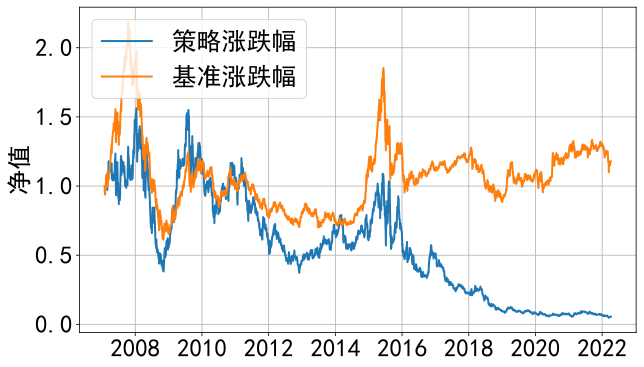

In [8]:
# ===计算策略评价指标
equity2 = equity.copy()
rtn, year_return, month_return = strategy_evaluate(equity2, select_stock)
print(rtn)
print(year_return)

# 绘制策略曲线
equity2 = equity2.reset_index()
# ===画图
draw_equity_curve_mat(equity2, data_dict={'策略涨跌幅': 'equity_curve', '基准涨跌幅': 'benchmark'}, date_col='交易日期')
# 如果上面的函数不能画图，就用下面的画图
# draw_equity_curve_plotly(equity2, data_dict={'策略涨跌幅': 'equity_curve', '基准涨跌幅': 'benchmark'}, date_col='交易日期')

<AxesSubplot:>

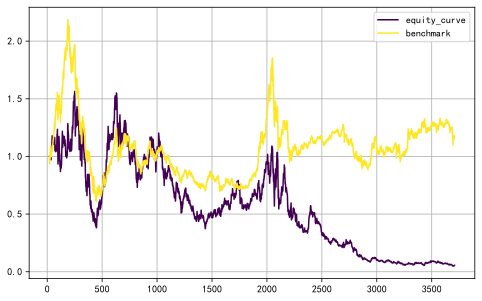

In [10]:
equity[['equity_curve','benchmark']].plot(kind='line', grid=True, colormap='viridis',figsize=(8,5), legend=True)
# plt.savefig('./figures/contrarian_week.png', dpi=1000)

**月度调仓**

In [15]:
period_df, equity, select_stock = factor_testing(df_month, '本周期涨跌幅', True)
rtn, year_return, month_return = strategy_evaluate(equity, select_stock)

          交易日期                       买入股票代码           买入股票名称  选股下周期涨跌幅                                         选股下周期每天涨跌幅      资金曲线
132 2018-02-28  sh603286 sz002054 sz002178   日盈电子 德美化工 延华智能   0.107711  [0.027522850026483914, -0.022919891834210726, ...  0.258321
133 2018-03-30  sh603225 sz002512 sz300476    新凤鸣 达华智能 胜宏科技  -0.046537  [0.002096104715321623, -0.025057989758549226, ...  0.246300
134 2018-04-27  sh603716 sz002717 sz300677    塞力斯 岭南股份 英科医疗  -0.098170  [0.04623791602102445, -0.010630796230534534, 0...  0.222120
135 2018-05-31  sh600666 sz300259 sz300547    奥瑞德 新天科技 川环科技  -0.110824  [-0.017445140114454416, -0.032261840474560155,...  0.197504
136 2018-06-29  sz002398 sz002451 sz300668   建研集团 摩恩电气 杰恩设计  -0.069269  [0.04351953779918594, 0.00903895942903743, -0....  0.183823
137 2018-07-31  sh600165 sz000576 sz300266   新日恒力 广东甘化 兴源环境  -0.295420  [-0.029362511910949407, -0.08014548467670302, ...  0.129518
138 2018-08-31  sz000669 sz000673 sz002789   金鸿控股 当代东方 建艺集团   0.076146  [0.0

<AxesSubplot:xlabel='交易日期'>

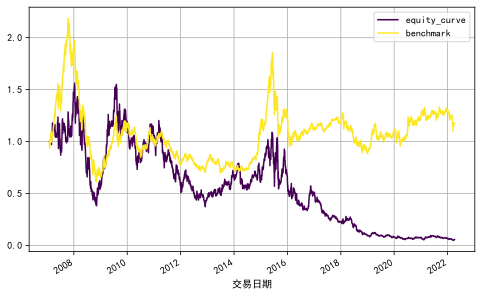

In [16]:
equity[['equity_curve','benchmark']].plot(kind='line', grid=True, colormap='viridis',figsize=(8,5), legend=True)
# plt.savefig('./figures/contrarian_month.png', dpi=1000)

In [ ]:
contrarian_month = factor_testing(df_month, '本周期涨跌幅', True)
contrarian_month.tail()

<AxesSubplot:xlabel='交易日期'>

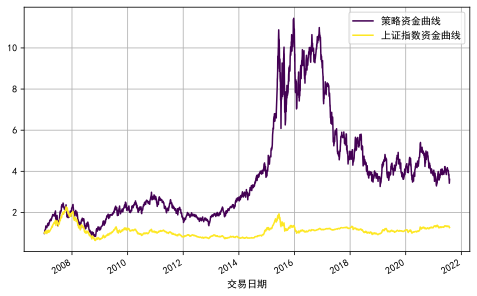

In [224]:
contrarian_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='viridis',figsize=(8,5), legend=True)
plt.savefig('./figures/contrarian_month.png', dpi=1000)

#### **惯性策略检验 (momentum strategy)**

**周度调仓**

In [225]:
momentum_week = factor_testing(df_week, '本周期涨跌幅', False)
momentum_week.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh603893 sh605358 sh688090 sh688099 sh688551 s...,瑞芯微 立昂微 瑞松科技 晶晨股份 科威尔 芯海科技 凤形股份 鑫铂股份 英搏尔 泰林生物,0.000616,0.001144,1.479492
2021-07-27,-0.024877,sh603893 sh605358 sh688090 sh688099 sh688551 s...,瑞芯微 立昂微 瑞松科技 晶晨股份 科威尔 芯海科技 凤形股份 鑫铂股份 英搏尔 泰林生物,0.016009,0.001162,1.442686
2021-07-28,-0.005794,sh603893 sh605358 sh688090 sh688099 sh688551 s...,瑞芯微 立昂微 瑞松科技 晶晨股份 科威尔 芯海科技 凤形股份 鑫铂股份 英搏尔 泰林生物,-0.048758,0.001106,1.434327
2021-07-29,0.014913,sh603893 sh605358 sh688090 sh688099 sh688551 s...,瑞芯微 立昂微 瑞松科技 晶晨股份 科威尔 芯海科技 凤形股份 鑫铂股份 英搏尔 泰林生物,0.086205,0.001201,1.455717
2021-07-30,-0.004209,sh603893 sh605358 sh688090 sh688099 sh688551 s...,瑞芯微 立昂微 瑞松科技 晶晨股份 科威尔 芯海科技 凤形股份 鑫铂股份 英搏尔 泰林生物,0.002394,0.001204,1.449590


<AxesSubplot:xlabel='交易日期'>

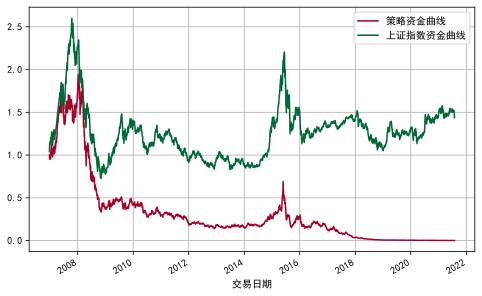

In [226]:
momentum_week[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlGn',figsize=(8,5), legend=True)
plt.savefig('./figures/momentum_week.png', dpi=1000)
#这个问题很大

**月度调仓**

In [227]:
momentum_month = factor_testing(df_month, '本周期涨跌幅', False)
momentum_month.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600032 sh603026 sh603876 sh605080 sh605117 s...,浙江新能 XD石大胜 鼎胜新材 浙江自然 德业股份 东鹏饮料 奥特维 天合光能 九联科技 传...,-0.005910,0.030976,1.296012
2021-07-27,-0.024877,sh600032 sh603026 sh603876 sh605080 sh605117 s...,浙江新能 XD石大胜 鼎胜新材 浙江自然 德业股份 东鹏饮料 奥特维 天合光能 九联科技 传...,-0.030313,0.030037,1.263770
2021-07-28,-0.005794,sh600032 sh603026 sh603876 sh605080 sh605117 s...,浙江新能 XD石大胜 鼎胜新材 浙江自然 德业股份 东鹏饮料 奥特维 天合光能 九联科技 传...,-0.022511,0.029361,1.256448
2021-07-29,0.014913,sh600032 sh603026 sh603876 sh605080 sh605117 s...,浙江新能 XD石大胜 鼎胜新材 浙江自然 德业股份 东鹏饮料 奥特维 天合光能 九联科技 传...,0.080387,0.031721,1.275185
2021-07-30,-0.004209,sh600032 sh603026 sh603876 sh605080 sh605117 s...,浙江新能 XD石大胜 鼎胜新材 浙江自然 德业股份 东鹏饮料 奥特维 天合光能 九联科技 传...,0.039448,0.032973,1.269818


<AxesSubplot:xlabel='交易日期'>

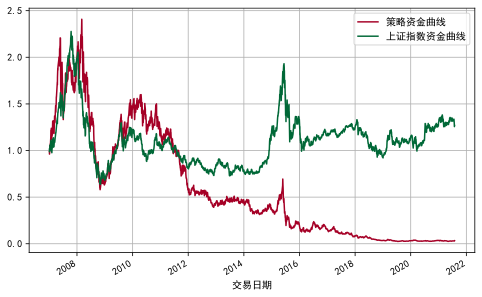

In [228]:
momentum_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlGn',figsize=(8,5), legend=True)
plt.savefig('./figures/momentum_month.png', dpi=1000)

#### **换手率因子检验 (turnover strategy)**

**低换手率的策略 - 周度调仓**

In [229]:
turnover_low_week = factor_testing(df_week, '换手率', True)
turnover_low_week.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600936 sh600939 sh601086 sh601228 sh601326 s...,广西广电 重庆建工 国芳集团 广州港 秦港股份 绿城水务 中新集团 京沪高铁 大丰实业 常青股份,-0.013280,2.055528,1.479492
2021-07-27,-0.024877,sh600936 sh600939 sh601086 sh601228 sh601326 s...,广西广电 重庆建工 国芳集团 广州港 秦港股份 绿城水务 中新集团 京沪高铁 大丰实业 常青股份,-0.006217,2.042749,1.442686
2021-07-28,-0.005794,sh600936 sh600939 sh601086 sh601228 sh601326 s...,广西广电 重庆建工 国芳集团 广州港 秦港股份 绿城水务 中新集团 京沪高铁 大丰实业 常青股份,-0.011576,2.019102,1.434327
2021-07-29,0.014913,sh600936 sh600939 sh601086 sh601228 sh601326 s...,广西广电 重庆建工 国芳集团 广州港 秦港股份 绿城水务 中新集团 京沪高铁 大丰实业 常青股份,0.003617,2.026406,1.455717
2021-07-30,-0.004209,sh600936 sh600939 sh601086 sh601228 sh601326 s...,广西广电 重庆建工 国芳集团 广州港 秦港股份 绿城水务 中新集团 京沪高铁 大丰实业 常青股份,-0.004082,2.018135,1.449590


<AxesSubplot:xlabel='交易日期'>

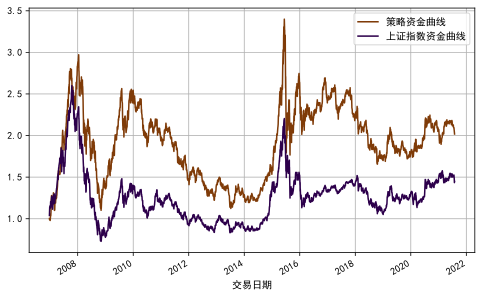

In [230]:
turnover_low_week[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='PuOr',figsize=(8,5), legend=True)
plt.savefig('./figures/turnover_low_week.png', dpi=1000)

**低换手率策略 - 月度调仓**

In [231]:
turnover_low_month = factor_testing(df_month, '换手率', True)
turnover_low_month.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600936 sh600939 sh601228 sh601326 sh601366 s...,广西广电 重庆建工 广州港 秦港股份 利群股份 绿城水务 中国核电 卫信康 好太太 兆丰股份,-0.009870,4.128585,1.296012
2021-07-27,-0.024877,sh600936 sh600939 sh601228 sh601326 sh601366 s...,广西广电 重庆建工 广州港 秦港股份 利群股份 绿城水务 中国核电 卫信康 好太太 兆丰股份,-0.005897,4.104237,1.263770
2021-07-28,-0.005794,sh600936 sh600939 sh601228 sh601326 sh601366 s...,广西广电 重庆建工 广州港 秦港股份 利群股份 绿城水务 中国核电 卫信康 好太太 兆丰股份,-0.015894,4.039005,1.256448
2021-07-29,0.014913,sh600936 sh600939 sh601228 sh601326 sh601366 s...,广西广电 重庆建工 广州港 秦港股份 利群股份 绿城水务 中国核电 卫信康 好太太 兆丰股份,0.001334,4.044392,1.275185
2021-07-30,-0.004209,sh600936 sh600939 sh601228 sh601326 sh601366 s...,广西广电 重庆建工 广州港 秦港股份 利群股份 绿城水务 中国核电 卫信康 好太太 兆丰股份,0.002956,4.056348,1.269818


<AxesSubplot:xlabel='交易日期'>

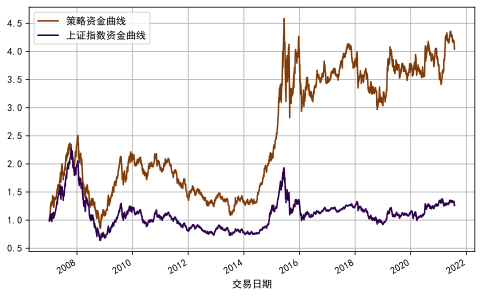

In [232]:
turnover_low_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='PuOr',figsize=(8,5), legend=True)
plt.savefig('./figures/turnover_low_month.png', dpi=1000)

**高换手率策略 - 周度调仓**

In [233]:
turnover_high_week = factor_testing(df_week, '换手率', False)
turnover_high_week.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh603171 sh605011 sh605028 sh605162 sh688501 s...,税友股份 杭州热电 世茂能源 新中港 青达环保 新致软件 华亚智能 泰福泵业 浩通科技 华蓝集团,0.010823,0.005510,1.479492
2021-07-27,-0.024877,sh603171 sh605011 sh605028 sh605162 sh688501 s...,税友股份 杭州热电 世茂能源 新中港 青达环保 新致软件 华亚智能 泰福泵业 浩通科技 华蓝集团,-0.055928,0.005202,1.442686
2021-07-28,-0.005794,sh603171 sh605011 sh605028 sh605162 sh688501 s...,税友股份 杭州热电 世茂能源 新中港 青达环保 新致软件 华亚智能 泰福泵业 浩通科技 华蓝集团,-0.039209,0.004998,1.434327
2021-07-29,0.014913,sh603171 sh605011 sh605028 sh605162 sh688501 s...,税友股份 杭州热电 世茂能源 新中港 青达环保 新致软件 华亚智能 泰福泵业 浩通科技 华蓝集团,0.017857,0.005087,1.455717
2021-07-30,-0.004209,sh603171 sh605011 sh605028 sh605162 sh688501 s...,税友股份 杭州热电 世茂能源 新中港 青达环保 新致软件 华亚智能 泰福泵业 浩通科技 华蓝集团,0.009525,0.005136,1.449590


<AxesSubplot:xlabel='交易日期'>

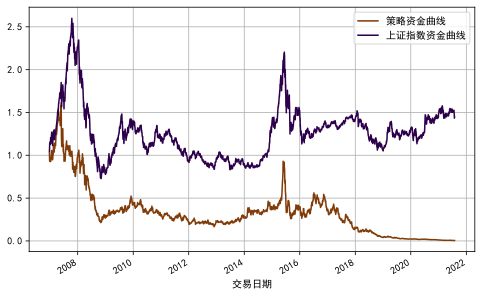

In [234]:
turnover_high_week[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='PuOr',figsize=(8,5), legend=True)
plt.savefig('./figures/turnover_high_week.png', dpi=1000)

**高换手率策略 - 月度调仓**

In [235]:
turnover_high_month = factor_testing(df_month, '换手率', False)
turnover_high_month.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600032 sh600906 sh601279 sh605196 sh605300 s...,浙江新能 财达证券 英利汽车 华通线缆 佳禾食品 野马电池 九联科技 传智教育 顺控发展 奇...,-0.034750,0.029314,1.296012
2021-07-27,-0.024877,sh600032 sh600906 sh601279 sh605196 sh605300 s...,浙江新能 财达证券 英利汽车 华通线缆 佳禾食品 野马电池 九联科技 传智教育 顺控发展 奇...,-0.033627,0.028328,1.263770
2021-07-28,-0.005794,sh600032 sh600906 sh601279 sh605196 sh605300 s...,浙江新能 财达证券 英利汽车 华通线缆 佳禾食品 野马电池 九联科技 传智教育 顺控发展 奇...,-0.021416,0.027722,1.256448
2021-07-29,0.014913,sh600032 sh600906 sh601279 sh605196 sh605300 s...,浙江新能 财达证券 英利汽车 华通线缆 佳禾食品 野马电池 九联科技 传智教育 顺控发展 奇...,0.039838,0.028826,1.275185
2021-07-30,-0.004209,sh600032 sh600906 sh601279 sh605196 sh605300 s...,浙江新能 财达证券 英利汽车 华通线缆 佳禾食品 野马电池 九联科技 传智教育 顺控发展 奇...,0.016205,0.029293,1.269818


<AxesSubplot:xlabel='交易日期'>

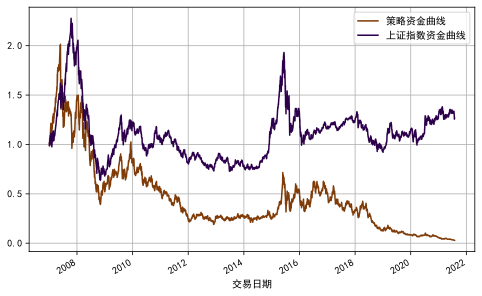

In [236]:
turnover_high_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='PuOr',figsize=(8,5), legend=True)
plt.savefig('./figures/turnover_high_month.png', dpi=1000)


#### **振幅1因子检验 (amplitude strategy 1)**

**低振幅1策略 - 周度调仓**

In [237]:
amplitude1_low_week = factor_testing(df_week, '振幅1', True)
amplitude1_low_week.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600939 sh601069 sh601086 sh601298 sh601319 s...,重庆建工 西部黄金 国芳集团 青岛港 中国人保 利群股份 浙商银行 中创物流 华丰股份 森林包装,-0.017193,0.924571,1.479492
2021-07-27,-0.024877,sh600939 sh601069 sh601086 sh601298 sh601319 s...,重庆建工 西部黄金 国芳集团 青岛港 中国人保 利群股份 浙商银行 中创物流 华丰股份 森林包装,-0.008758,0.916473,1.442686
2021-07-28,-0.005794,sh600939 sh601069 sh601086 sh601298 sh601319 s...,重庆建工 西部黄金 国芳集团 青岛港 中国人保 利群股份 浙商银行 中创物流 华丰股份 森林包装,-0.016244,0.901586,1.434327
2021-07-29,0.014913,sh600939 sh601069 sh601086 sh601298 sh601319 s...,重庆建工 西部黄金 国芳集团 青岛港 中国人保 利群股份 浙商银行 中创物流 华丰股份 森林包装,0.002575,0.903907,1.455717
2021-07-30,-0.004209,sh600939 sh601069 sh601086 sh601298 sh601319 s...,重庆建工 西部黄金 国芳集团 青岛港 中国人保 利群股份 浙商银行 中创物流 华丰股份 森林包装,-0.006808,0.897754,1.449590


<AxesSubplot:xlabel='交易日期'>

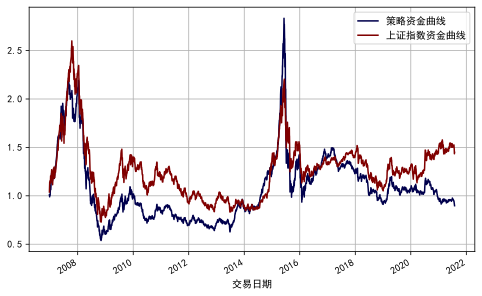

In [238]:
amplitude1_low_week[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='seismic',figsize=(8,5), legend=True)
plt.savefig('./figures/amplitude1_low_week.png', dpi=1000)


**低振幅1策略 - 月度调仓**

In [239]:
amplitude1_low_month = factor_testing(df_month, '振幅1', True)
amplitude1_low_month.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh601069 sh601611 sh601916 sh601975 sh603199 s...,西部黄金 中国核建 浙商银行 招商南油 九华旅游 爱丽家居 通达电气 中国通号 中国广核 兆...,-0.012806,1.302275,1.296012
2021-07-27,-0.024877,sh601069 sh601611 sh601916 sh601975 sh603199 s...,西部黄金 中国核建 浙商银行 招商南油 九华旅游 爱丽家居 通达电气 中国通号 中国广核 兆...,-0.004926,1.295861,1.263770
2021-07-28,-0.005794,sh601069 sh601611 sh601916 sh601975 sh603199 s...,西部黄金 中国核建 浙商银行 招商南油 九华旅游 爱丽家居 通达电气 中国通号 中国广核 兆...,-0.023848,1.264956,1.256448
2021-07-29,0.014913,sh601069 sh601611 sh601916 sh601975 sh603199 s...,西部黄金 中国核建 浙商银行 招商南油 九华旅游 爱丽家居 通达电气 中国通号 中国广核 兆...,0.000749,1.265904,1.275185
2021-07-30,-0.004209,sh601069 sh601611 sh601916 sh601975 sh603199 s...,西部黄金 中国核建 浙商银行 招商南油 九华旅游 爱丽家居 通达电气 中国通号 中国广核 兆...,-0.000027,1.265870,1.269818


<AxesSubplot:xlabel='交易日期'>

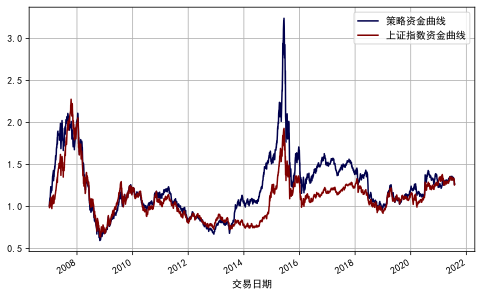

In [240]:
amplitude1_low_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='seismic',figsize=(8,5), legend=True)
plt.savefig('./figures/amplitude1_low_month.png', dpi=1000)


**高振幅1策略 - 周度调仓**

In [241]:
amplitude1_high_week = factor_testing(df_week, '振幅1', False)
amplitude1_high_week.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh603026 sh603171 sh605011 sh605028 sh605162 s...,石大胜华 税友股份 杭州热电 世茂能源 新中港 芯源微 海目星 芯海科技 华菱线缆 泰林生物,-0.005322,0.605097,1.479492
2021-07-27,-0.024877,sh603026 sh603171 sh605011 sh605028 sh605162 s...,石大胜华 税友股份 杭州热电 世茂能源 新中港 芯源微 海目星 芯海科技 华菱线缆 泰林生物,-0.032832,0.585230,1.442686
2021-07-28,-0.005794,sh603026 sh603171 sh605011 sh605028 sh605162 s...,石大胜华 税友股份 杭州热电 世茂能源 新中港 芯源微 海目星 芯海科技 华菱线缆 泰林生物,-0.042968,0.560084,1.434327
2021-07-29,0.014913,sh603026 sh603171 sh605011 sh605028 sh605162 s...,石大胜华 税友股份 杭州热电 世茂能源 新中港 芯源微 海目星 芯海科技 华菱线缆 泰林生物,0.066951,0.597582,1.455717
2021-07-30,-0.004209,sh603026 sh603171 sh605011 sh605028 sh605162 s...,石大胜华 税友股份 杭州热电 世茂能源 新中港 芯源微 海目星 芯海科技 华菱线缆 泰林生物,0.011318,0.604345,1.449590


<AxesSubplot:xlabel='交易日期'>

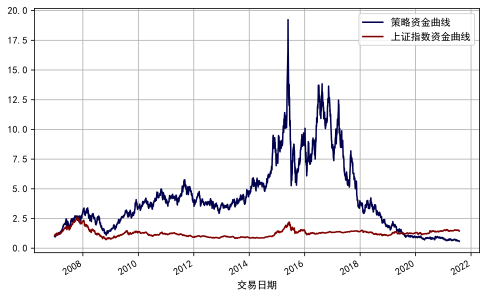

In [242]:
amplitude1_high_week[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='seismic',figsize=(8,5), legend=True)
plt.savefig('./figures/amplitude1_high_week.png', dpi=1000)


**高振幅1策略 - 月度调仓**

In [243]:
amplitude1_high_month = factor_testing(df_month, '振幅1', False)
amplitude1_high_month.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600032 sh603876 sh603893 sh605117 sh605499 s...,浙江新能 鼎胜新材 瑞芯微 德业股份 东鹏饮料 九联科技 海优新材 传智教育 盛讯达 聚灿光电,-0.005901,0.400463,1.296012
2021-07-27,-0.024877,sh600032 sh603876 sh603893 sh605117 sh605499 s...,浙江新能 鼎胜新材 瑞芯微 德业股份 东鹏饮料 九联科技 海优新材 传智教育 盛讯达 聚灿光电,-0.016340,0.393919,1.263770
2021-07-28,-0.005794,sh600032 sh603876 sh603893 sh605117 sh605499 s...,浙江新能 鼎胜新材 瑞芯微 德业股份 东鹏饮料 九联科技 海优新材 传智教育 盛讯达 聚灿光电,-0.033507,0.380720,1.256448
2021-07-29,0.014913,sh600032 sh603876 sh603893 sh605117 sh605499 s...,浙江新能 鼎胜新材 瑞芯微 德业股份 东鹏饮料 九联科技 海优新材 传智教育 盛讯达 聚灿光电,0.058216,0.402884,1.275185
2021-07-30,-0.004209,sh600032 sh603876 sh603893 sh605117 sh605499 s...,浙江新能 鼎胜新材 瑞芯微 德业股份 东鹏饮料 九联科技 海优新材 传智教育 盛讯达 聚灿光电,0.047504,0.422023,1.269818


<AxesSubplot:xlabel='交易日期'>

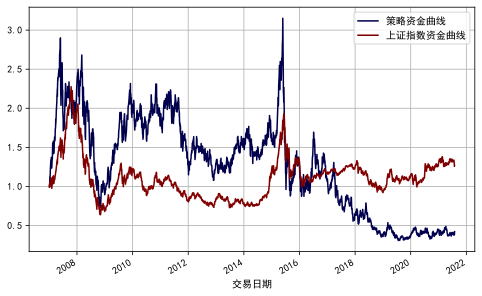

In [244]:
amplitude1_high_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='seismic',figsize=(8,5), legend=True)
plt.savefig('./figures/amplitude1_high_month.png', dpi=1000)


#### **振幅2因子检验 (amplitude strategy 2)**

**低振幅2策略 - 周度调仓**

In [245]:
amplitude2_low_week = factor_testing(df_week, '振幅2', True)
amplitude2_low_week.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600928 sh601077 sh601228 sh601319 sh601366 s...,西安银行 渝农商行 广州港 中国人保 利群股份 绿城水务 紫金银行 浙商银行 中国通号 青岛银行,-0.015742,0.584717,1.479492
2021-07-27,-0.024877,sh600928 sh601077 sh601228 sh601319 sh601366 s...,西安银行 渝农商行 广州港 中国人保 利群股份 绿城水务 紫金银行 浙商银行 中国通号 青岛银行,-0.009839,0.578963,1.442686
2021-07-28,-0.005794,sh600928 sh601077 sh601228 sh601319 sh601366 s...,西安银行 渝农商行 广州港 中国人保 利群股份 绿城水务 紫金银行 浙商银行 中国通号 青岛银行,-0.003000,0.577227,1.434327
2021-07-29,0.014913,sh600928 sh601077 sh601228 sh601319 sh601366 s...,西安银行 渝农商行 广州港 中国人保 利群股份 绿城水务 紫金银行 浙商银行 中国通号 青岛银行,-0.003379,0.575276,1.455717
2021-07-30,-0.004209,sh600928 sh601077 sh601228 sh601319 sh601366 s...,西安银行 渝农商行 广州港 中国人保 利群股份 绿城水务 紫金银行 浙商银行 中国通号 青岛银行,-0.012692,0.567975,1.449590


<AxesSubplot:xlabel='交易日期'>

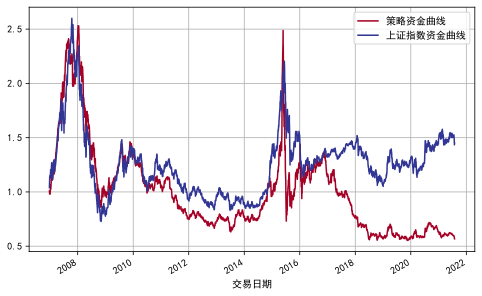

In [246]:
amplitude2_low_week[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlBu',figsize=(8,5), legend=True)
plt.savefig('./figures/amplitude2_low_week.png', dpi=1000)


**低振幅2策略 - 月度调仓**

In [247]:
amplitude2_low_month = factor_testing(df_month, '振幅2', True)
amplitude2_low_month.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600928 sh601069 sh601228 sh601326 sh601368 s...,西安银行 西部黄金 广州港 秦港股份 绿城水务 北元集团 紫金银行 浙商银行 华丰股份 中国广核,-0.016067,1.146251,1.296012
2021-07-27,-0.024877,sh600928 sh601069 sh601228 sh601326 sh601368 s...,西安银行 西部黄金 广州港 秦港股份 绿城水务 北元集团 紫金银行 浙商银行 华丰股份 中国广核,-0.006935,1.138302,1.263770
2021-07-28,-0.005794,sh600928 sh601069 sh601228 sh601326 sh601368 s...,西安银行 西部黄金 广州港 秦港股份 绿城水务 北元集团 紫金银行 浙商银行 华丰股份 中国广核,-0.011892,1.124764,1.256448
2021-07-29,0.014913,sh600928 sh601069 sh601228 sh601326 sh601368 s...,西安银行 西部黄金 广州港 秦港股份 绿城水务 北元集团 紫金银行 浙商银行 华丰股份 中国广核,-0.000859,1.123799,1.275185
2021-07-30,-0.004209,sh600928 sh601069 sh601228 sh601326 sh601368 s...,西安银行 西部黄金 广州港 秦港股份 绿城水务 北元集团 紫金银行 浙商银行 华丰股份 中国广核,-0.006048,1.117003,1.269818


<AxesSubplot:xlabel='交易日期'>

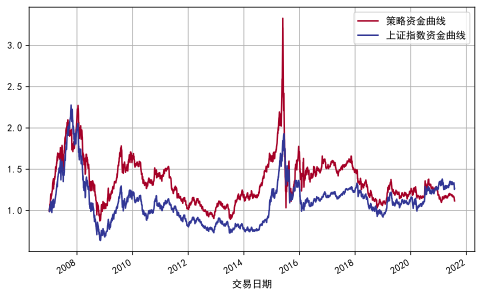

In [248]:
amplitude2_low_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlBu',figsize=(8,5), legend=True)
plt.savefig('./figures/amplitude2_low_month.png', dpi=1000)


**高振幅2策略 - 周度调仓**

In [249]:
amplitude2_high_week = factor_testing(df_week, '振幅2', False)
amplitude2_high_week.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh688087 sh688239 sh688329 sh688789 sh688793 s...,英科再生 航宇科技 艾隆科技 宏华数科 倍轻松 利和兴 英诺激光 浩通科技 华蓝集团 中熔电气,0.013077,0.107655,1.479492
2021-07-27,-0.024877,sh688087 sh688239 sh688329 sh688789 sh688793 s...,英科再生 航宇科技 艾隆科技 宏华数科 倍轻松 利和兴 英诺激光 浩通科技 华蓝集团 中熔电气,-0.023562,0.105119,1.442686
2021-07-28,-0.005794,sh688087 sh688239 sh688329 sh688789 sh688793 s...,英科再生 航宇科技 艾隆科技 宏华数科 倍轻松 利和兴 英诺激光 浩通科技 华蓝集团 中熔电气,0.008874,0.106052,1.434327
2021-07-29,0.014913,sh688087 sh688239 sh688329 sh688789 sh688793 s...,英科再生 航宇科技 艾隆科技 宏华数科 倍轻松 利和兴 英诺激光 浩通科技 华蓝集团 中熔电气,0.038147,0.110097,1.455717
2021-07-30,-0.004209,sh688087 sh688239 sh688329 sh688789 sh688793 s...,英科再生 航宇科技 艾隆科技 宏华数科 倍轻松 利和兴 英诺激光 浩通科技 华蓝集团 中熔电气,-0.002035,0.109873,1.449590


<AxesSubplot:xlabel='交易日期'>

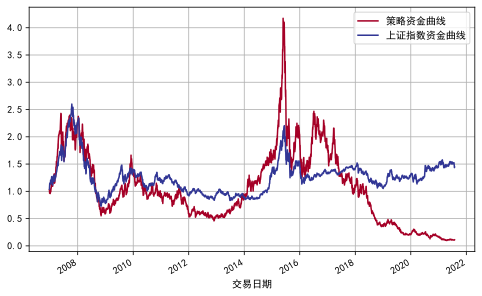

In [250]:
amplitude2_high_week[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlBu',figsize=(8,5), legend=True)
plt.savefig('./figures/amplitude2_high_week.png', dpi=1000)


**高振幅2策略 - 月度调仓**

In [251]:
amplitude2_high_month = factor_testing(df_month, '振幅1', False)
amplitude2_high_month.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600032 sh603876 sh603893 sh605117 sh605499 s...,浙江新能 鼎胜新材 瑞芯微 德业股份 东鹏饮料 九联科技 海优新材 传智教育 盛讯达 聚灿光电,-0.005901,0.400463,1.296012
2021-07-27,-0.024877,sh600032 sh603876 sh603893 sh605117 sh605499 s...,浙江新能 鼎胜新材 瑞芯微 德业股份 东鹏饮料 九联科技 海优新材 传智教育 盛讯达 聚灿光电,-0.016340,0.393919,1.263770
2021-07-28,-0.005794,sh600032 sh603876 sh603893 sh605117 sh605499 s...,浙江新能 鼎胜新材 瑞芯微 德业股份 东鹏饮料 九联科技 海优新材 传智教育 盛讯达 聚灿光电,-0.033507,0.380720,1.256448
2021-07-29,0.014913,sh600032 sh603876 sh603893 sh605117 sh605499 s...,浙江新能 鼎胜新材 瑞芯微 德业股份 东鹏饮料 九联科技 海优新材 传智教育 盛讯达 聚灿光电,0.058216,0.402884,1.275185
2021-07-30,-0.004209,sh600032 sh603876 sh603893 sh605117 sh605499 s...,浙江新能 鼎胜新材 瑞芯微 德业股份 东鹏饮料 九联科技 海优新材 传智教育 盛讯达 聚灿光电,0.047504,0.422023,1.269818


<AxesSubplot:xlabel='交易日期'>

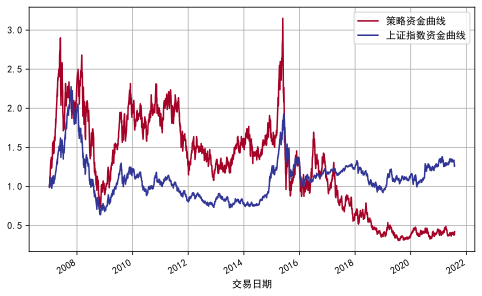

In [252]:
amplitude2_high_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlBu',figsize=(8,5), legend=True)
plt.savefig('./figures/amplitude2_high_month.png', dpi=1000)


#### **经典的小市值策略**

**总市值 - 周度调仓**

In [6]:
total_mktcap_week = factor_testing(df_week, '总市值', True)
total_mktcap_week.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600455 sh600778 sh603029 sh603286 sh603356 s...,博通股份 友好集团 天鹅股份 日盈电子 华菱精工 中源家居 原尚股份 中公高科 滨海能源 正...,-0.011493,691.932748,1.479492
2021-07-27,-0.024877,sh600455 sh600778 sh603029 sh603286 sh603356 s...,博通股份 友好集团 天鹅股份 日盈电子 华菱精工 中源家居 原尚股份 中公高科 滨海能源 正...,0.001231,692.784774,1.442686
2021-07-28,-0.005794,sh600455 sh600778 sh603029 sh603286 sh603356 s...,博通股份 友好集团 天鹅股份 日盈电子 华菱精工 中源家居 原尚股份 中公高科 滨海能源 正...,-0.017000,681.007172,1.434327
2021-07-29,0.014913,sh600455 sh600778 sh603029 sh603286 sh603356 s...,博通股份 友好集团 天鹅股份 日盈电子 华菱精工 中源家居 原尚股份 中公高科 滨海能源 正...,0.022705,696.469167,1.455717
2021-07-30,-0.004209,sh600455 sh600778 sh603029 sh603286 sh603356 s...,博通股份 友好集团 天鹅股份 日盈电子 华菱精工 中源家居 原尚股份 中公高科 滨海能源 正...,-0.006409,692.005231,1.449590


<AxesSubplot:xlabel='交易日期'>

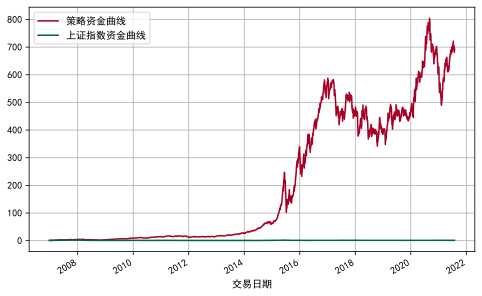

In [254]:
total_mktcap_week[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlGn',figsize=(8,5), legend=True)
plt.savefig('./figures/total_mktcap_week.png', dpi=1000)


**总市值 - 月度调仓**

In [255]:
total_mktcap_month = factor_testing(df_month, '总市值', True)
total_mktcap_month.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh600099 sh600455 sh603029 sh603090 sh603356 s...,林海股份 博通股份 天鹅股份 宏盛股份 华菱精工 中源家居 原尚股份 中公高科 滨海能源 正...,-0.018034,343.406781,1.296012
2021-07-27,-0.024877,sh600099 sh600455 sh603029 sh603090 sh603356 s...,林海股份 博通股份 天鹅股份 宏盛股份 华菱精工 中源家居 原尚股份 中公高科 滨海能源 正...,-0.002106,342.683517,1.263770
2021-07-28,-0.005794,sh600099 sh600455 sh603029 sh603090 sh603356 s...,林海股份 博通股份 天鹅股份 宏盛股份 华菱精工 中源家居 原尚股份 中公高科 滨海能源 正...,-0.022301,335.041270,1.256448
2021-07-29,0.014913,sh600099 sh600455 sh603029 sh603090 sh603356 s...,林海股份 博通股份 天鹅股份 宏盛股份 华菱精工 中源家居 原尚股份 中公高科 滨海能源 正...,0.027290,344.184431,1.275185
2021-07-30,-0.004209,sh600099 sh600455 sh603029 sh603090 sh603356 s...,林海股份 博通股份 天鹅股份 宏盛股份 华菱精工 中源家居 原尚股份 中公高科 滨海能源 正...,0.000092,344.216077,1.269818


<AxesSubplot:xlabel='交易日期'>

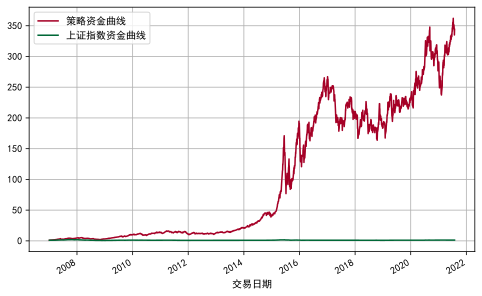

In [256]:
total_mktcap_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlGn',figsize=(8,5), legend=True)
plt.savefig('./figures/total_mktcap_month.png', dpi=1000)

**流通市值 - 周度调仓**

In [257]:
cir_mktcap_week = factor_testing(df_week, '流通市值', True)
cir_mktcap_week.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh605188 sh605198 sh688067 sh688092 sh688156 s...,国光连锁 德利股份 爱威科技 爱科科技 路德环境 瑞晟智能 青达环保 金冠电气 上纬新材 科...,-0.020087,327.769381,1.479492
2021-07-27,-0.024877,sh605188 sh605198 sh688067 sh688092 sh688156 s...,国光连锁 德利股份 爱威科技 爱科科技 路德环境 瑞晟智能 青达环保 金冠电气 上纬新材 科...,-0.001307,327.341105,1.442686
2021-07-28,-0.005794,sh605188 sh605198 sh688067 sh688092 sh688156 s...,国光连锁 德利股份 爱威科技 爱科科技 路德环境 瑞晟智能 青达环保 金冠电气 上纬新材 科...,-0.044667,312.719670,1.434327
2021-07-29,0.014913,sh605188 sh605198 sh688067 sh688092 sh688156 s...,国光连锁 德利股份 爱威科技 爱科科技 路德环境 瑞晟智能 青达环保 金冠电气 上纬新材 科...,0.018148,318.394821,1.455717
2021-07-30,-0.004209,sh605188 sh605198 sh688067 sh688092 sh688156 s...,国光连锁 德利股份 爱威科技 爱科科技 路德环境 瑞晟智能 青达环保 金冠电气 上纬新材 科...,0.025381,326.476015,1.449590


<AxesSubplot:xlabel='交易日期'>

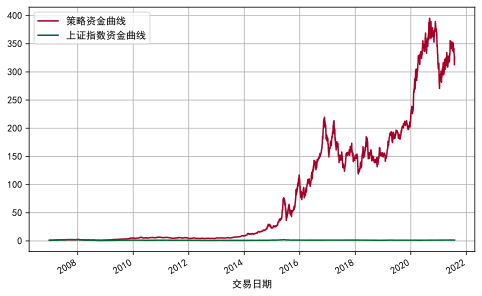

In [258]:
cir_mktcap_week[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlGn',figsize=(8,5), legend=True)
plt.savefig('./figures/cir_mktcap_week.png', dpi=1000)

**流通市值 - 月度调仓**

In [259]:
cir_mktcap_month = factor_testing(df_month, '流通市值', True)
cir_mktcap_month.tail()

,指数涨跌幅,持有股票代码,持有股票名称,涨跌幅,策略资金曲线,上证指数资金曲线
交易日期,,,,,,
2021-07-26,-0.023366,sh605188 sh605198 sh605318 sh688092 sh688156 s...,国光连锁 德利股份 法狮龙 爱科科技 路德环境 瑞晟智能 正弦电气 力源科技 上纬新材 通源环境,-0.013344,41.774027,1.296012
2021-07-27,-0.024877,sh605188 sh605198 sh605318 sh688092 sh688156 s...,国光连锁 德利股份 法狮龙 爱科科技 路德环境 瑞晟智能 正弦电气 力源科技 上纬新材 通源环境,-0.005702,41.535815,1.263770
2021-07-28,-0.005794,sh605188 sh605198 sh605318 sh688092 sh688156 s...,国光连锁 德利股份 法狮龙 爱科科技 路德环境 瑞晟智能 正弦电气 力源科技 上纬新材 通源环境,-0.041466,39.813501,1.256448
2021-07-29,0.014913,sh605188 sh605198 sh605318 sh688092 sh688156 s...,国光连锁 德利股份 法狮龙 爱科科技 路德环境 瑞晟智能 正弦电气 力源科技 上纬新材 通源环境,0.017487,40.509711,1.275185
2021-07-30,-0.004209,sh605188 sh605198 sh605318 sh688092 sh688156 s...,国光连锁 德利股份 法狮龙 爱科科技 路德环境 瑞晟智能 正弦电气 力源科技 上纬新材 通源环境,0.034488,41.906820,1.269818


<AxesSubplot:xlabel='交易日期'>

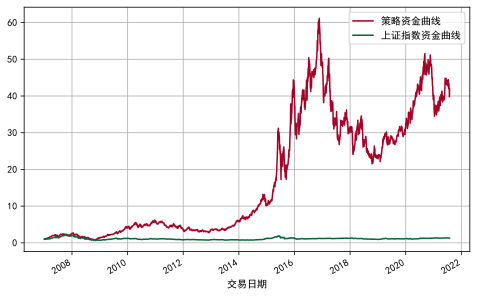

In [260]:
cir_mktcap_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlGn',figsize=(8,5), legend=True)
plt.savefig('./figures/cir_mktcap_month.png', dpi=1000)

#### **量价相关性 - 量价背离策略**

**量价相关性 - 周度调仓**

**选择量价背离的10只股票，即因子值corr最小的**

In [7]:
quan_price_week = factor_testing(df_week, '量价相关系数', True)
quan_price_week.tail()

KeyError: 'Column not found: 量价相关系数'

In [ ]:
quan_price_week[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlGn',figsize=(8,5), legend=True)
plt.savefig('./figures/quan_price_week.png', dpi=1000)

**量价相关性 - 月度调仓**

**选择量价背离的10只股票，即因子值corr最小的**

In [ ]:
quan_price_month = factor_testing(df_week, '量价相关系数', True)
quan_price_month.tail()

In [ ]:
quan_price_month[['策略资金曲线','上证指数资金曲线']].plot(kind='line', grid=True, colormap='RdYlGn',figsize=(8,5), legend=True)
plt.savefig('./figures/quan_price_month.png', dpi=1000)

**结论是量价背离要比量价相向要好很多。但是是放量下跌好还是缩量上涨好呢？**
- 量价背离中，放量下跌要比缩量上涨更好
- 量价同向中，放量上涨比缩量下跌更差

**数据规律总结：放量后，行情会反转**

后续优化思路：
- 本身量价相关系数的rolling参数是超参数，可以调
- 计算相关系数使用的是复权的收盘价，然而收盘价未必足够稳定以反应相关性，可以使用比如高低均价等等